#### Avaliação Prática dtLabs
##### Autor: Anthonny Dayvson Lino Paz
##### Questão 01: Estimar trajetória 3D com ICP usando nuvens de pontos
##### Requisitos: ICP do zero, comparação com ground-truth

Importando Bibliotecas quem poder ser usadas.

In [64]:
import numpy as np
import trimesh
import os
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

Montando o Drive

In [65]:
# Só no Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

Carregando os dados do Drive, usando Colab

In [66]:
# Caminho da pasta com os arquivos .obj
#kitti_dataset = '/content/drive/MyDrive/Demos/dtLabs/KITTI-Sequence'
# Caminho para o arquivo .npy
#ground_truth = '/content/drive/MyDrive/Demos/dtLabs/ground_truth.npy'

Carregando os dados Localmente

In [67]:
# Caminho da pasta com os arquivos .obj
kitti_dataset = '..\dtLabs\KITTI-Sequence'
# Caminho para o arquivo .npy
ground_truth = '..\dtLabs\ground_truth.npy'

 Para carregar a nuvem de pontos, que estão nos arquivos .obj, você pode
utilizar a biblioteca Trimesh.

Exemplo de como carregar a point cloud:
  - import trimesh
  - point_cloud = trimesh.load(“000000_points.obj”).vertice



https://en.wikipedia.org/wiki/Point_cloud
  - Point Cloud: Is a discrete set of data points in space. The points may represent a 3D shape or object. Each point position has its set of Cartesia Coordinates (X, Y, Z). Points may contain data other than position such as RGB colors, normals, timestamps and others. Point clouds are generally produced by 3D scanners or photogrammetry software, which measure many points on the external surfaces of objects around them. As the output of 3D scanning processes, point clouds are used for many purposes, including to create 3D computer-aided design (CAD) or geographic information system (GIS) models for manufactured parts, for metrology and quality inspection, and for a multitude of visualizing, animating, rendering, and mass customization applications.
  - Alignment and registration: When scanning a scene in real world using Lidar, the captured point clouds contain snippets of the scene, which requires alignment to generate a full map of the scanned enviroment. Point clouds are often aligned with 3D models or with other point clouds, a process termed point set registration.

In [68]:
point_clouds = []
for root, _, files in os.walk(kitti_dataset):
    for file in sorted(files):
        if file.endswith('.obj'):
            mesh = trimesh.load(os.path.join(root, file))
            vertices = np.asarray(mesh.vertices)
            point_clouds.append(vertices)

ground_truth = np.load(ground_truth)

In [69]:
point_clouds[0]

array([[-9.110238, 18.638599,  0.909355],
       [-9.151207, 18.5732  ,  0.908344],
       [-9.206173, 18.536804,  0.908331],
       ...,
       [ 1.438176,  3.840138, -1.773556],
       [ 1.419202,  3.825716, -1.76457 ],
       [ 1.507196,  4.092375, -1.895561]])

In [70]:
ground_truth.shape

(30, 4, 4)

# Observações

  - Vamos usar a ground_truh para comparar o resultado. Com ela, será possível verificar se estamos chegando em um resposta próxima da realidade.
  - Como descrito no corpo da questão, não é permitido usar bibliotecas que já possuam o algoritmo do ICP implementado. Portanto, não podemos suar a implementação das bibliotecas como: Open3D ou PCL. Contudo, podemos usar o algoritmo dessas bibliotecas como ground-truth para verificarmos se nossa implementação está correta.
  - Podemos usar bibliotecas como SciPy, NumPy, MatPlotLib.
  - É obrigatório que seja feita a demonstração do caminho percorrido, em todos os eixos (XYZ), pelo carro, ou seja, devemos mostar um plot 3D da trajetória estimada pelo veículo. Ou, se possível, a matriz de transformação final, em coordendas homogêneas, do carro.

# ICP

ICP: It has been a mainstay of geometric registration in both research and industry for many years. The input are two point clouds and an initial transformation that roughly aligns the source point cloud to the target point cloud. The output is a refined transformation that tightly aligns the two point clouds. A helper function draw_registration_result visualizes the alignment during the registration process.

  - The Iterative Closest Point (ICP) algorithm can be used to align two point clouds that have an overlap between them, and are separated by a rigid transform.
  - Point clouds with elastic transformsca can also be aligned by using a non-rigid variant of the ICP (NICP). With advancements in Machine Learning in recent years, point cloud registration may also be done using end-to-end neural networks.
  - For industrial metrology or inspection using industrial computed tomography, the point cloud of a manufactured part can be aligned to an existing model and compared to check for differences. Geometric dimensions and tolerances can also be extracted directly from the point cloud.

Point-set Registration(en.wikipedia.org/wiki/Point_cloud)

- In Computer Vision, patter recognition, and robotics, point-set registration, also known as point-cloud registration or scan matching, is the process of finding a spatial transformation (e.g., scaling, rotation and translation) that aligns two point clouds. The purpose of finding such a transformation includes merging multiple data sets into a globally consistent model (or coordinate frame), and mapping a new measurement to a known data set to identify features or to estimate its pose. Raw 3D point cloud data are typically obtained from Lidars and RGB-D Cameras. 3D point clouds can also be generated from computer vision algorithms such as triangulation, bundle adjustment, and more recently, monocular image depth estimation using deep learning. For 2D point set registration used in image processing and feature-based image registration, a point set may be 2d pixe coordinates obtained by feature extraction from an image, for example corner detection. Point cloud registration has extensive applications in autonomous driving, motion estimation and 3D reconstruction, object detection and pose estimation, robotic manipulation, simultaneous localization and mapping (SLAM), panaroma stitching, virtual and augmented reality, and medical imaging.

#Formulation

The problem may be summarized as follows: Let {M, S} be two finite size point sets in a finite-dimensional real vector space R^d, which contain M and N points respectively(e.g., d = 3, recovers the typical case of when M and S are 3D point sets). The Problem is to find a transformation to be applied to the moving "model" point set M such that the difference (typically defined in the sense of point-wise Euclidean Distance) between M and the static "scene" set S is minimized. In other words, a mapping from R^d to R^d is desired which yields the best alignment between the transformed "model" set and the "scene" set. The mapping may consist of a rigid or non-rigid transformation. The transformation model may be written as T, using which the trasnformed, registred model point set is:
  T(M)
- The output of a point set registration algorithm is therefore the optimal transformation T* such that M is best aligned to S, according to some defined notion of distance fucntion dist(.,.):

  - T* = argmin dist(T(M), S)
    - T £ {\displaystyle {\mathcal {T}}}
  - where {\displaystyle {\mathcal {T}}} is used to denote the set of all possible transformations that the optimization tries to search for. The most popular choice of the distance function is to take the square of the Euclidean Distance for every pair of points:
    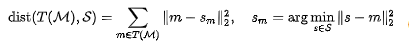
    
where ||.||2 denotes the vector 2-norm, Sm is the corresponding point in set S that attains the shortest distance to a given point m in set M after transformation. Minimizing such a fucntion in rigid registration is equivalent to solving a least squares problem.

# Types of algorithms

When the correspondences (i.e., Sm <-> m) are given before the optimization, for example, using features matching techniques, then optimization only needs to estimate te transformation. This type of registration is called correspondence-bases registration. On the other hand, if the correspondences are unknown, then the optimization is required to jointly find out the correspondences and transformation together. This type of registration is called simultaneous pose and correspondence registration.

  - Rigid Registration: Given two point sets, rigid registration yields a rigid transformation which maps one point set to the other. A rigid transformation is defined as a transformation that does not change the distance between any two points. Typically such a transformation consistis of translation and rotation. In rare cases, the point set may also be mirrored. In robotics and computer vision, rigid registration has the most applications.

  - Non-Rigid Registration: Given two point sets, non-rigid registration yields a non-rigid transformation which maps one point set to the other. Non-rigid transformations include affine transformations such as scaling and shear mapping. However, in the context of point set registration, non-rigid registration typically involves nonlinear transformation. If the eigenmodes of variation of the point set are known, the nonlinear transformation may be parametrized by the eigenvalues. A nonlinear transformation may also be parametrized as a thin plate spline.
  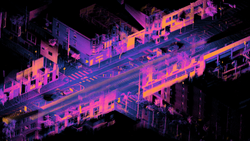

  Registered point cloud from a lidar mounted on a moving car.

Simultaneous pose and correspondence registration

- Iterative Closest Point (ICP): The ICP algorithm was introduced by Besl and McKay. The algorithm performs rigid registration in an iterative fashion by alternating in (i)  given the transformation, finding the closest point in S for every point in M; and (ii) given the correspondeces, finding the best rigid transformation by solving the least squares problem (cb.2). As such, it works best if the initial pose of M is sufficiently close to S. In pseudocode, the basic algorithm is implemented as follows:

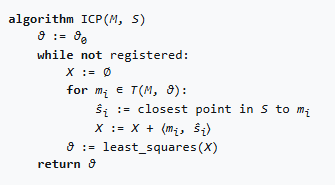

- Here, the function least_squares performos least squares optimization to minimize the distance in each of the <mi, ^si> pairs, using the closed-form solutions by Horn and Arun.
- Because the cost function of registration depends on finding the closest point in S to every point in M, it can change as the algorithm is running. As such, it is difficult to prove that ICP will in fact converge exactly to the local optimum. In fact, empirically, ICP and EM-ICP do not converge to the local minimum of the cost fucntion. Nonetheless, because ICP is intuitive to understand and straightforward to implement, it remains the most commonly used point set registration algorithm. Many variants of ICP have been proposed, affecting all phases of the algorithm from the selection and matching of points to the minimization strategy. For example, the expectation maximization algorithm is applied to the ICP algorithm to form the EM-ICP method, and the Levenberg-Marquardt algorithm is applied to the ICP algorithm to form the LM-ICP method.

Iterative Closest Point(ICP)
  
  - Is a point cloud registration algorithm employed to minimize the difference between two clouds of points. ICP is often used to reconstruct 2D or 3D surfaces from different scans, to localize robots and achieve optimal path planning (especially when wheel odometry is unreliable due to slippery terrain), to co-register bone models, etc.

  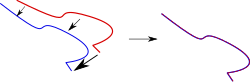

  - Overview: The Iterative Closest Point algorithm keeps one point cloud, the reference or target, fixed, while transforming the other, the source, to best match the reference. The transformation (combination of translation and rotation) is iteratively estimated in order to minimize an error metric, typically the sum of squared differences between  the coordinates of the matched pairs. ICP is one of the widely used algorithms is aligning three dimensional models given an initial guess of the rigid transformation required. The ICP algorithm was first introduced by Chen and Medioni, and Besl and McKay.
    - Inputs: Reference and source point clouds, initial estimation of the transformation to align the source to the reference (optional), criteria for stopping the iterations.
    - Output: Refined transformation.
    - Essentially, the algorithm steps are:
      1. For each point(from the whole set of vertices usually referred to as dense or a selection of pairs of vertices from each model) in the source point cloud, match the closest point in the reference point cloud (or a selected set).
      2. Estimate the combination of rotation and translation using a root mean square point-to-point distance metric minimization technique which will best align each source point to its match found in the previous step. This step may also involve weighting points and rejecting outliers prior to alignment.
      3. Transform the source points using the obtained transformation.
      4. Iterate (re-assicociate the points, and so on).
    - Zhang proposes a modified k-d tree algorithm for efficient closest point computation. In this work a statistical method based on the distance distribution is used to deal with outliers, occlusion, appearance, and disappeareance, which enables subset-subset matching.

    - There exist many ICP variants, from which point-to-point and point-to-plane are the most popular. The latter usually performs better in structured environments.

In [71]:
def run_icp_open3d(source_np, target_np, threshold=1.0, init=np.eye(4), max_iter=50):
    # Converte numpy arrays para o3d.geometry.PointCloud
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_np)

    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_np)

    # Executa ICP do Open3D
    reg = o3d.pipelines.registration.registration_icp(
        source, target, threshold, init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter)
    )

    return reg.transformation



In [72]:
# Implementando ICP do zero por partes

def best_fit_transform(A, B):
  # Vamos calcular a transformação rígida (R, t) que alinha A em B
  assert A.shape == B.shape

  centroid_A = np.mean(A, axis=0)
  centroid_B = np.mean(B, axis=0)

  AA = A - centroid_A
  BB = B - centroid_B

  H = AA.T @ BB
  U, S, Vt = np.linalg.svd(H)
  R = Vt.T @ U.T

  if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = Vt.T @ U.T

  t = centroid_B.T - R @ centroid_A.T

  return R, t.reshape(3, 1)

In [ ]:
import numpy as np
from scipy.spatial import KDTree

def best_fit_transform_point_to_plane(source, target, normals):
    """
    Resolve o sistema linear A x = b para minimizar o erro point-to-plane.
    source: pontos transformados (N,3)
    target: pontos correspondentes (N,3)
    normals: normais em target (N,3)
    """
    A = []
    b = []

    for p, q, n in zip(source, target, normals):
        cross = np.cross(p, n)  # produto vetorial
        A.append(np.hstack((cross, n)))  # [p x n | n]
        b.append(np.dot(n, q - p))       # n • (q - p)

    A = np.array(A)
    b = np.array(b).reshape(-1, 1)

    # Resolve o sistema linear Ax = b por SVD
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    # Extrai rotação pequena (ângulos) e translação
    rot_vector = x[:3].flatten()
    t = x[3:].reshape(3, 1)

    # Converte vetor de rotação (ângulos pequenos) para matriz
    angle = np.linalg.norm(rot_vector)
    if angle < 1e-12:
        R = np.eye(3)
    else:
        axis = rot_vector / angle
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)

    return R, t


In [73]:
from re import T
def icp(A, B, max_iterations=20, tolerance=1e-6):
  src = A.copy()
  prev_error = float('inf')
  R_total = np.eye(3)
  t_total = np.zeros((3,))

  for i in range(max_iterations):
    tree = KDTree(B)
    distances, indices = tree.query(src)

    matched_B = B[indices]

    R, t = best_fit_transform(src, matched_B)

    src = (R @ src.T).T + t

    R_total = R @ R_total
    t_total = R @ t_total + t

    mean_error = np.mean(distances)
    if abs(prev_error - mean_error) < tolerance:
      break
    prev_error = mean_error

  return R_total, t_total

In [74]:
def ICP(M, S, init_pose=None, iterations=50, tolerance=1e-6, distance_threshold=1.0):
    if init_pose is None:
        R = np.eye(3)
        t = np.zeros((3, 1))
    else:
        R, t = init_pose

    prev_error = float('inf')

    for iteration in range(iterations):
        M_transformed = (R @ M.T).T + t.T
        tree = KDTree(S)
        distances, indices = tree.query(M_transformed)
        S_matched = S[indices]

        mask = distances < distance_threshold
        if np.sum(mask) < 3:
            break

        R_new, t_new = best_fit_transform(M_transformed[mask], S_matched[mask])
        R = R_new @ R
        t = R_new @ t + t_new

        mean_error = np.mean(distances)
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return R, t


In [ ]:
def ICP_point_to_plane(M, S, S_normals, init_pose=None, iterations=50, tolerance=1e-6, distance_threshold=1.0):
    if init_pose is None:
        R = np.eye(3)
        t = np.zeros((3, 1))
    else:
        R, t = init_pose

    prev_error = float('inf')

    for it in range(iterations):
        M_transformed = (R @ M.T).T + t.T
        tree = KDTree(S)
        distances, indices = tree.query(M_transformed)

        mask = distances < distance_threshold
        if np.sum(mask) < 3:
            break

        matched_S = S[indices][mask]
        matched_M = M_transformed[mask]
        matched_normals = S_normals[indices][mask]

        R_delta, t_delta = best_fit_transform_point_to_plane(matched_M, matched_S, matched_normals)

        R = R_delta @ R
        t = R_delta @ t + t_delta

        mean_error = np.mean(distances[mask])
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return R, t


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def estimate_normals_manual(points, radius=1.0, max_nn=30):
    """
    Estima normais para uma nuvem de pontos 3D manualmente.
    
    points: numpy array (N,3)
    radius: raio máximo para buscar vizinhos
    max_nn: número máximo de vizinhos a considerar
    
    Retorna: numpy array (N,3) com as normais estimadas.
    """
    normals = np.zeros_like(points)
    
    # Encontrar vizinhos usando KDTree
    nbrs = NearestNeighbors(radius=radius, algorithm='kd_tree').fit(points)
    
    # Para cada ponto, achar vizinhos no raio e calcular normal
    for i, point in enumerate(points):
        # indices dos vizinhos no raio
        indices = nbrs.radius_neighbors([point], radius=radius, return_distance=False)[0]
        
        # limitar a quantidade máxima de vizinhos
        if len(indices) > max_nn:
            indices = indices[:max_nn]
        
        neighbors = points[indices]
        
        # Centralizar vizinhos
        neighbors_centered = neighbors - neighbors.mean(axis=0)
        
        # Matriz de covariância
        cov = np.cov(neighbors_centered, rowvar=False)
        
        # Autovalores e autovetores
        eigvals, eigvecs = np.linalg.eigh(cov)
        
        # Normal é o autovetor com menor autovalor
        normal = eigvecs[:, np.argmin(eigvals)]
        
        # Garantir que a normal esteja apontando para cima (opcional)
        # Por exemplo, fazer o componente z ser positivo
        if normal[2] < 0:
            normal = -normal
        
        normals[i] = normal
    
    return normals


In [75]:
# Calculando a trajetória

trajectory = [np.eye(4)]

for i in range(len(point_clouds) -1):
  A = point_clouds[i]
  B = point_clouds[i + 1]

  R, t = ICP(A, B, iterations=50, distance_threshold=1.0)

  T = np.eye(4)
  T[:3, :3] = R
  T[:3, 3] = t.flatten()

  T_absolute = trajectory[-1] @ T
  trajectory.append(T_absolute)



In [76]:
icp_estimated = np.array([T[:3, 3] for T in trajectory])
gt_positions = np.array([gt[:3, 3] for gt in ground_truth[:len(icp_estimated)]])

R_align, t_align = best_fit_transform(icp_estimated, gt_positions)

icp_estimated_aligned = np.array([
    (R_align @ p.reshape(3, 1) + t_align).flatten() for p in icp_estimated
])

# Corrige a origem para começar exatamente no mesmo ponto que a GT
offset = gt_positions[0] - icp_estimated_aligned[0]
icp_estimated_aligned += offset


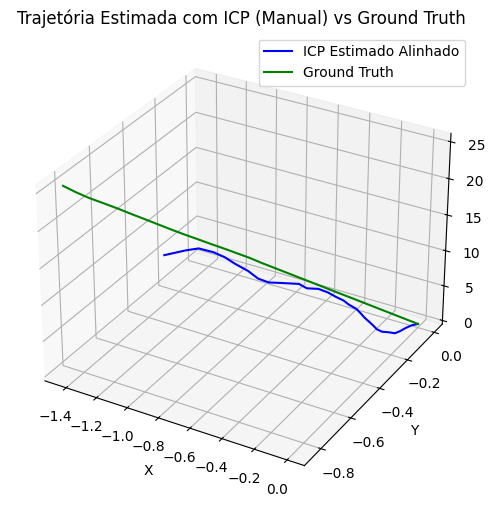

In [77]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(icp_estimated_aligned[:, 0], icp_estimated_aligned[:, 1], icp_estimated_aligned[:, 2],
        label='ICP Estimado Alinhado', color='blue')

ax.plot(gt_positions[:, 0], gt_positions[:, 1], gt_positions[:, 2],
        label='Ground Truth', color='green')

ax.set_title("Trajetória Estimada com ICP (Manual) vs Ground Truth")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


In [78]:
for i in range(30):
    print(f"Frame {i} - Estimado: {icp_estimated_aligned[i]}, Ground Truth: {gt_positions[i]}")

Frame 0 - Estimado: [5.55111512e-17 3.33066907e-16 0.00000000e+00], Ground Truth: [ 5.551115e-17  3.330669e-16 -4.440892e-16]
Frame 1 - Estimado: [-0.00795594 -0.03884873  0.5067594 ], Ground Truth: [-0.04690294 -0.02839928  0.8586941 ]
Frame 2 - Estimado: [-0.00754207 -0.08498807  1.03004045], Ground Truth: [-0.09374345 -0.05676064  1.716275  ]
Frame 3 - Estimado: [-1.54514751e-03 -1.33930972e-01  1.57291797e+00], Ground Truth: [-0.1406429  -0.08515762  2.574964  ]
Frame 4 - Estimado: [-3.27965521e-04 -1.74649300e-01  2.06869812e+00], Ground Truth: [-0.1874858 -0.1135202  3.432648 ]
Frame 5 - Estimado: [-0.01500766 -0.19974219  2.59937531], Ground Truth: [-0.2343818 -0.141915   4.291335 ]
Frame 6 - Estimado: [-0.0349143  -0.22993986  3.14689805], Ground Truth: [-0.2812195 -0.1702743  5.148987 ]
Frame 7 - Estimado: [-0.05341357 -0.24636788  3.6849271 ], Ground Truth: [-0.3281178 -0.1986703  6.007777 ]
Frame 8 - Estimado: [-0.06466187 -0.25576376  4.23054398], Ground Truth: [-0.3749547 